In [1]:
import pandas
import numpy as np
import time
import torch
import matplotlib.pyplot as plt

In [2]:
class NNet(torch.nn.Module):

    def __init__(self, n_inputs, architecture, n_outputs, device):
        # Call parent class (torch.nn.Module) constructor so we can do gpu computations
        super().__init__()  
        
        self.device = device
        
        # Create an empty list if we get linear architecture
        if architecture == 0 or architecture == [] or architecture == [0]:
            self.architecture = []
        else:
            self.architecture = architecture

        # Necessary for gpu computations
        self.hidden_layers = torch.nn.ModuleList()

        for ar in self.architecture:
            self.hidden_layers.append( torch.nn.Sequential(
                torch.nn.Linear(n_inputs, ar),
                torch.nn.Tanh()))
            n_inputs = ar

        self.output_layer = torch.nn.Linear(n_inputs, n_outputs)
            
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None

        self.error_trace = []
        
        self.to(self.device)

    def forward(self, X):  
        
        Y = X
        for hidden_layer in self.hidden_layers:
            Y = hidden_layer(Y)
        Y = self.output_layer(Y)
        return Y

    def train(self, X, T, n_epochs, learning_rate):
        
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float().to(self.device)
        if not isinstance(T, torch.Tensor):
            T = torch.from_numpy(T).float().to(self.device)
        
        if self.Xmeans is None:
            self.Xmeans = X.mean(0)
            self.Xstds = X.std(0)
            self.Xstds[self.Xstds == 0] = 1
            self.Tmeans = T.mean(0)
            self.Tstds = T.std(0)
            self.Tstds[self.Tstds == 0] = 1
            
        # Standardize inputs and targets
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds
        
        # Use Adam for optimization
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        mse_func = torch.nn.MSELoss()
         
        for epoch in range(n_epochs):
            Y = self(X)
            mse = mse_func(T, Y)
            mse.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            mse = mse**(1/2)
            error = mse * self.Tstds
            self.error_trace = error
            
            if (epoch+1 == n_epochs or (epoch+1) % (n_epochs // 10) == 0):
                print(f'Epoch {epoch+1:d}: RMSE {self.error_trace[0]:.3f}')
                
    def use(self, X):
 
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float().to(self.device)

        X = (X - self.Xmeans) / self.Xstds
        
        Z = self.forward(X)
        Y = Z * self.Tstds + self.Tmeans
        
        # Convert CUDA tensor to numpy so we can use matplotlib
        return Y.detach().cpu().numpy()

In [3]:
def partition(X, T, n_folds, random_shuffle=True):
    
    rows = np.arange(X.shape[0])
    np.random.shuffle(rows)
    X = X[rows, :]
    T = T[rows, :]
    
    n_samples = X.shape[0]
    n_per_fold = n_samples // n_folds
    n_last_fold = n_samples - n_per_fold * (n_folds - 1)
    
    folds = []
    start = 0
    for fold1 in range(n_folds - 1):
        folds.append( (X[start:start + n_per_fold, :], T[start:start + n_per_fold, :]) )
        start += n_per_fold
    folds.append((X[start:, :], T[start:, :]))
    
    Xvalidate, Tvalidate = folds[0]
    Xtest, Ttest = folds[1]
    Xtrain, Ttrain = np.vstack([X for (X, _) in folds[2:]]), np.vstack([T for (_, T) in folds[2:]])
    
    return Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest

# Root mean squared error
def RMSE(A, B):
    return np.sqrt(np.mean((A - B)**2))

In [4]:
# Allows us to test multiple network parameters at once, meaning we have to do less coding.
def train_nnets(X, T, n_folds, epoch_options, architecture_options, device):
    
    lr = 0.01
    Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest = partition(X, T, n_folds)
    results = pandas.DataFrame(columns=['Epochs', 'Architecture', 'Learning Rate', 'RMSE Train', 'RMSE Val', 'RMSE Test'])
    
    for ne in epoch_options:
        for ar in architecture_options:
            nnet = NNet(Xtrain.shape[1], ar, Ttrain.shape[1], device)
            nnet.train(Xtrain, Ttrain, ne, lr)
                
            results.loc[len(results)] = [ne, ar, lr, 
                                         RMSE(Ttrain, nnet.use(Xtrain)), 
                                         RMSE(Tvalidate, nnet.use(Xvalidate)), 
                                         RMSE(Ttest, nnet.use(Xtest))]
    results.sort_values('RMSE Val')
    return results

In [5]:
df = pandas.read_csv('Team Bugatti Weather Project - weather_data_bugatti.csv', na_values='?')
df = df.drop(['Date', 'Time', 'CPU Utilization(%)', 'Response Time(sec)'], axis=1)
df = df.dropna()

X = df.iloc[:-1, :].values
T_temp = df.iloc[:, 0:1].values
T_hum = df.iloc[:, 1:2].values
T_pres = df.iloc[:, 2:3].values

In [6]:
cpu_time = time.time()

results_temp = train_nnets(X, T_temp, n_folds = 5, 
                            epoch_options = [1000, 2000, 3000], 
                            architecture_options = [[0], [10], [10, 10]], 
                            device = 'cpu')

results_hum = train_nnets(X, T_hum, n_folds = 5, 
                            epoch_options = [1000, 2000, 3000], 
                            architecture_options = [[0], [10], [10, 10]], 
                            device = 'cpu')

results_pres = train_nnets(X, T_hum, n_folds = 5, 
                            epoch_options = [1000, 2000, 3000], 
                            architecture_options = [[0], [10], [10, 10]], 
                            device = 'cpu')

elapsed_time = (time.time() - cpu_time)
print(f'Took {elapsed_time:.2f} seconds with CPU')

Epoch 100: RMSE 2.025
Epoch 200: RMSE 1.304
Epoch 300: RMSE 0.722
Epoch 400: RMSE 0.348
Epoch 500: RMSE 0.147
Epoch 600: RMSE 0.055
Epoch 700: RMSE 0.018
Epoch 800: RMSE 0.005
Epoch 900: RMSE 0.001
Epoch 1000: RMSE 0.000
Epoch 100: RMSE 1.235
Epoch 200: RMSE 0.719
Epoch 300: RMSE 0.513
Epoch 400: RMSE 0.384
Epoch 500: RMSE 0.308
Epoch 600: RMSE 0.261
Epoch 700: RMSE 0.229
Epoch 800: RMSE 0.206
Epoch 900: RMSE 0.189
Epoch 1000: RMSE 0.175
Epoch 100: RMSE 1.310
Epoch 200: RMSE 0.550
Epoch 300: RMSE 0.303
Epoch 400: RMSE 0.221
Epoch 500: RMSE 0.177
Epoch 600: RMSE 0.146
Epoch 700: RMSE 0.123
Epoch 800: RMSE 0.105
Epoch 900: RMSE 0.091
Epoch 1000: RMSE 0.080
Epoch 200: RMSE 0.021
Epoch 400: RMSE 0.000
Epoch 600: RMSE 0.000
Epoch 800: RMSE 0.000
Epoch 1000: RMSE 0.000
Epoch 1200: RMSE 0.000
Epoch 1400: RMSE 0.000
Epoch 1600: RMSE 0.000
Epoch 1800: RMSE 0.000
Epoch 2000: RMSE 0.000
Epoch 200: RMSE 0.682
Epoch 400: RMSE 0.433
Epoch 600: RMSE 0.296
Epoch 800: RMSE 0.200
Epoch 1000: RMSE 0.136


In [7]:
results_temp = results_temp.sort_values('RMSE Val')
results_hum = results_hum.sort_values('RMSE Val')
results_pres = results_pres.sort_values('RMSE Val')

In [8]:
print(results_temp)

  Epochs Architecture  Learning Rate  RMSE Train  RMSE Val  RMSE Test
3   2000          [0]           0.01    0.000001  0.000001   0.000002
6   3000          [0]           0.01    0.000005  0.000005   0.000005
0   1000          [0]           0.01    0.000262  0.000269   0.000259
8   3000     [10, 10]           0.01    0.024323  0.025020   0.023935
7   3000         [10]           0.01    0.039289  0.039704   0.040248
5   2000     [10, 10]           0.01    0.066422  0.074404   0.070556
4   2000         [10]           0.01    0.080261  0.082521   0.083183
2   1000     [10, 10]           0.01    0.079487  0.083387   0.081924
1   1000         [10]           0.01    0.175179  0.182032   0.183663


In [9]:
print(results_hum)

  Epochs Architecture  Learning Rate  RMSE Train  RMSE Val  RMSE Test
6   3000          [0]           0.01    0.000003  0.000003   0.000003
3   2000          [0]           0.01    0.000005  0.000005   0.000005
0   1000          [0]           0.01    0.010346  0.009902   0.009980
7   3000         [10]           0.01    0.056699  0.055563   0.055013
5   2000     [10, 10]           0.01    0.081303  0.076457   0.090780
8   3000     [10, 10]           0.01    0.083880  0.086670   0.091868
2   1000     [10, 10]           0.01    0.117976  0.119022   0.120216
4   2000         [10]           0.01    0.137188  0.140435   0.136323
1   1000         [10]           0.01    0.323320  0.344867   0.333645


In [10]:
print(results_pres)

  Epochs Architecture  Learning Rate  RMSE Train  RMSE Val  RMSE Test
6   3000          [0]           0.01    0.000004  0.000003   0.000003
3   2000          [0]           0.01    0.000509  0.000523   0.000508
8   3000     [10, 10]           0.01    0.060192  0.061740   0.062904
7   3000         [10]           0.01    0.070412  0.076617   0.081241
5   2000     [10, 10]           0.01    0.079036  0.085387   0.081616
4   2000         [10]           0.01    0.121474  0.118395   0.133834
2   1000     [10, 10]           0.01    0.157227  0.160807   0.179856
1   1000         [10]           0.01    0.371296  0.346204   0.370888
0   1000          [0]           0.01    0.742586  0.763716   0.742346


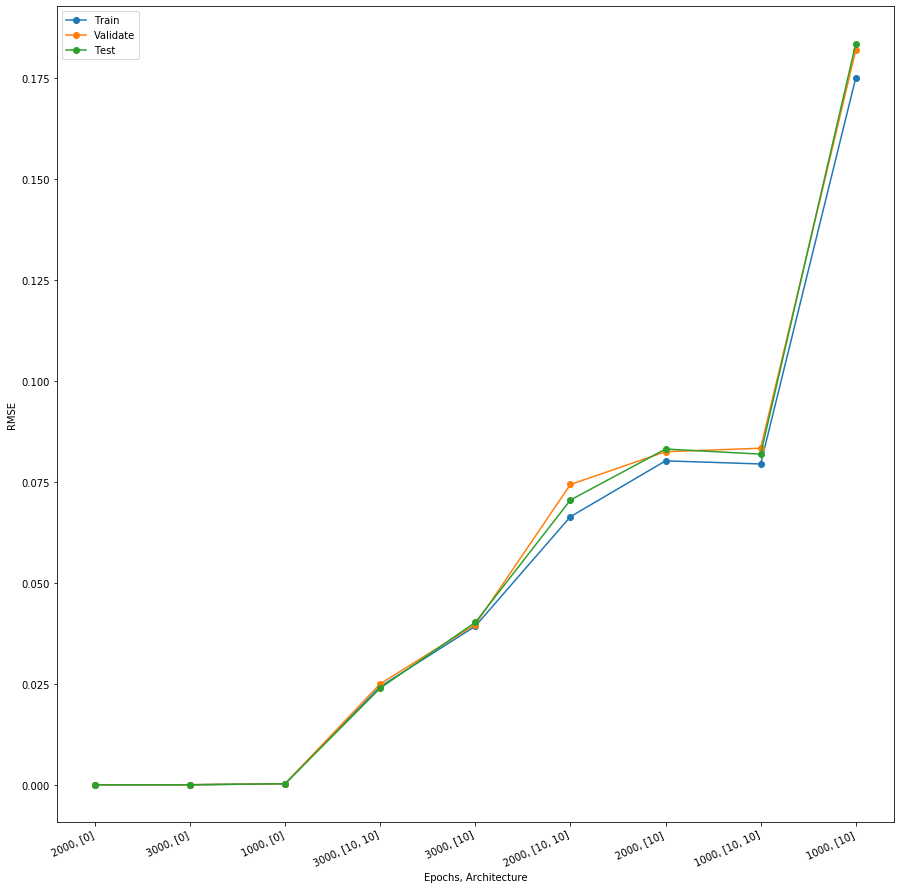

In [11]:
fig = plt.figure(figsize=(15, 15))

plt.subplot(1, 1, 1)
xs = range(results_temp.shape[0])
plt.plot(xs, results_temp[['RMSE Train', 'RMSE Val', 'RMSE Test']], 'o-')
xticks = results_temp[['Epochs', 'Architecture']].apply(lambda x: f'{x[0]}, {x[1]}', axis=1)
plt.xticks(range(len(xticks)), xticks, rotation=25, ha='right')
plt.xlabel('Epochs, Architecture')
plt.ylabel('RMSE')
plt.legend(('Train', 'Validate', 'Test'))

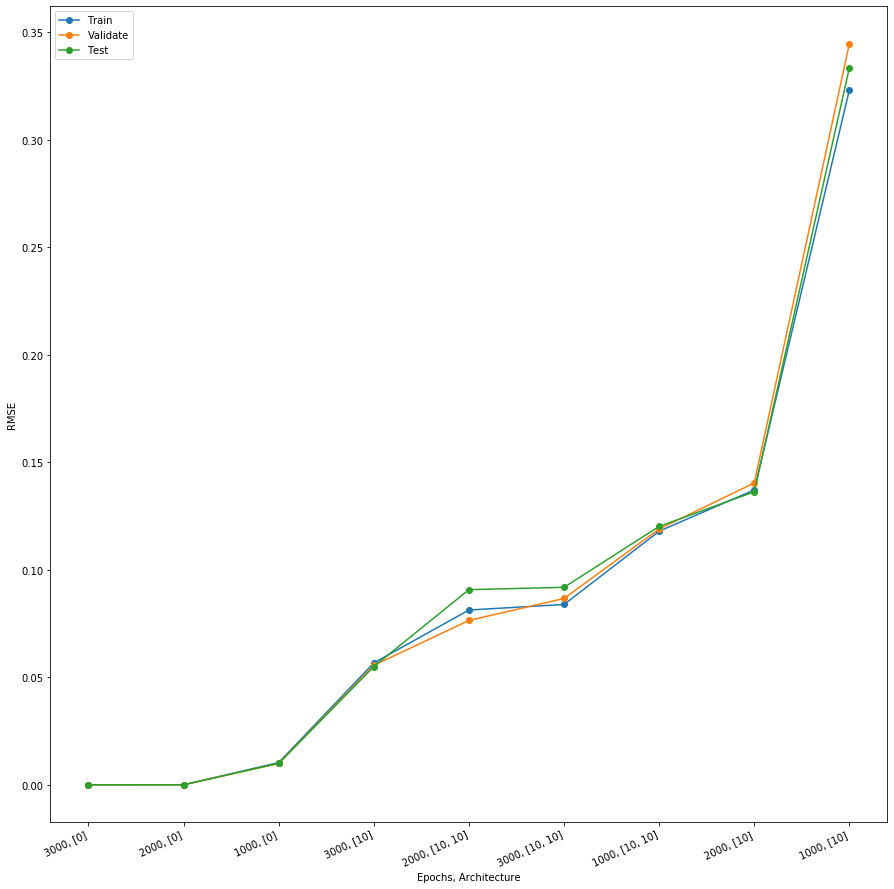

In [12]:
fig = plt.figure(figsize=(15, 15))

plt.subplot(1, 1, 1)
xs = range(results_hum.shape[0])
plt.plot(xs, results_hum[['RMSE Train', 'RMSE Val', 'RMSE Test']], 'o-')
xticks = results_hum[['Epochs', 'Architecture']].apply(lambda x: f'{x[0]}, {x[1]}', axis=1)
plt.xticks(range(len(xticks)), xticks, rotation=25, ha='right')
plt.xlabel('Epochs, Architecture')
plt.ylabel('RMSE')
plt.legend(('Train', 'Validate', 'Test'))

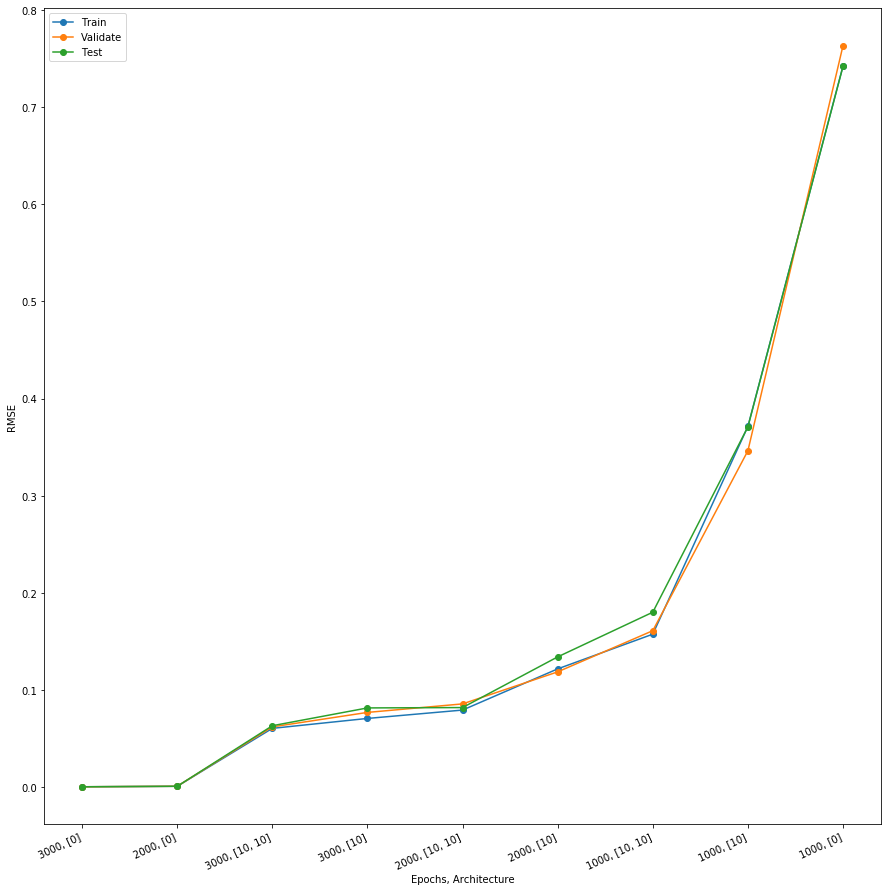

In [13]:
fig = plt.figure(figsize=(15, 15))

plt.subplot(1, 1, 1)
xs = range(results_pres.shape[0])
plt.plot(xs, results_pres[['RMSE Train', 'RMSE Val', 'RMSE Test']], 'o-')
xticks = results_pres[['Epochs', 'Architecture']].apply(lambda x: f'{x[0]}, {x[1]}', axis=1)
plt.xticks(range(len(xticks)), xticks, rotation=25, ha='right')
plt.xlabel('Epochs, Architecture')
plt.ylabel('RMSE')
plt.legend(('Train', 'Validate', 'Test'))